In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'datetime': ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 na_values=['?'], 
                 low_memory=False)


<font color=#0b5bdb> **Dataset Description:**</font>

**The dataset contains measurements of electric power consumption in a household over four years (December 2006 to November 2010). The data includes the following columns:**

- **Date:** Date in format dd/mm/yyyy
- **Time:** Time in format hh:mm:ss
- **Global_active_power:** Household global minute-averaged active power (in kilowatts)
- **Global_reactive_power:** Household global minute-averaged reactive power (in kilowatts) 
- **Voltage:** Minute-averaged voltage (in volts)
- **Global_intensity:** Minute-averaged current intensity (in amperes)
- **Sub_metering_1:** Energy sub-metering No. 1 (in watt-hours of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
- **Sub_metering_2:** Energy sub-metering No. 2 (in watt-hours of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
- **Sub_metering_2:** Energy sub-metering No. 3 (in watt-hours of active energy). It corresponds to an electric water-heater and an air-conditioner.- Source ---> Hebrail, Georges and Alice Berard. 2006. Individual Household Electric Power Consumption. UCI Machine Learning Repository. https://doi.org/10.24432/C58K54.


In [3]:
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
np.round(df.describe(),2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280.00,2049280.00,2049280.00,2049280.00,2049280.00,2049280.00,2049280.00
mean,1.09,0.12,240.84,4.63,1.12,1.30,6.46
std,1.06,0.11,3.24,4.44,6.15,5.82,8.44
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00
25%,0.31,0.05,238.99,1.40,0.00,0.00,0.00
50%,0.60,0.10,241.01,2.60,0.00,0.00,1.00
75%,1.53,0.19,242.89,6.40,0.00,1.00,17.00
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00


In [5]:
# Drop rows with missing values
df.dropna(inplace=True)

# Convert relevant columns to numeric
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')


In [6]:
# Resample to hourly data
df_hourly = df.resample('H', on='datetime').mean()


In [7]:
df_hourly.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [8]:
# Feature Engineering
df_hourly['year'] = df_hourly.index.year
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek # 0=Monday, 6=Sunday
df_hourly['month'] = df_hourly.index.month
df_hourly['lag_1'] = df_hourly['Global_active_power'].shift(1) # Previous hour consumption (assumed)
df_hourly['lag_24'] = df_hourly['Global_active_power'].shift(24) # Consumption from 24 hours ago
df_hourly.dropna(inplace=True)


In [9]:
df_hourly.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,hour,dayofweek,month,lag_1,lag_24
datetime,,,,,,,,,,,,,
2006-12-17 17:00:00,3.406767,0.166633,234.229833,14.510000,0.0,0.466667,16.816667,2006,17,6,12,3.326033,4.222889
2006-12-17 18:00:00,3.697100,0.135067,234.372333,15.750000,0.0,0.000000,16.833333,2006,18,6,12,3.406767,3.632200
2006-12-17 19:00:00,2.908400,0.265167,233.195667,12.516667,0.0,0.516667,16.683333,2006,19,6,12,3.697100,3.400233
2006-12-17 20:00:00,3.361500,0.271500,236.426500,14.276667,0.0,1.116667,17.116667,2006,20,6,12,2.908400,3.268567
2006-12-17 21:00:00,3.040767,0.267967,239.104167,12.716667,0.0,1.200000,17.500000,2006,21,6,12,3.361500,3.056467


In [10]:
np.round(df_hourly.describe(),2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,hour,dayofweek,month,lag_1,lag_24
count,33983.00,33983.00,33983.00,33983.00,33983.00,33983.00,33983.00,33983.00,33983.00,33983.00,33983.00,33983.00,33983.00
mean,1.09,0.12,240.84,4.63,1.12,1.30,6.46,2008.42,11.50,2.99,6.46,1.09,1.09
std,0.90,0.07,3.00,3.76,3.54,4.20,7.35,1.12,6.93,2.00,3.42,0.90,0.90
min,0.12,0.00,225.83,0.50,0.00,0.00,0.00,2006.00,0.00,0.00,1.00,0.12,0.12
25%,0.34,0.08,239.18,1.51,0.00,0.00,0.65,2007.00,5.00,1.00,3.00,0.34,0.34
50%,0.80,0.11,240.98,3.42,0.00,0.33,1.65,2008.00,12.00,3.00,6.00,0.80,0.80
75%,1.58,0.15,242.69,6.60,0.00,0.65,14.22,2009.00,18.00,5.00,9.00,1.58,1.58
max,6.56,0.77,251.90,28.38,48.37,46.43,21.55,2010.00,23.00,6.00,12.00,6.56,6.56


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


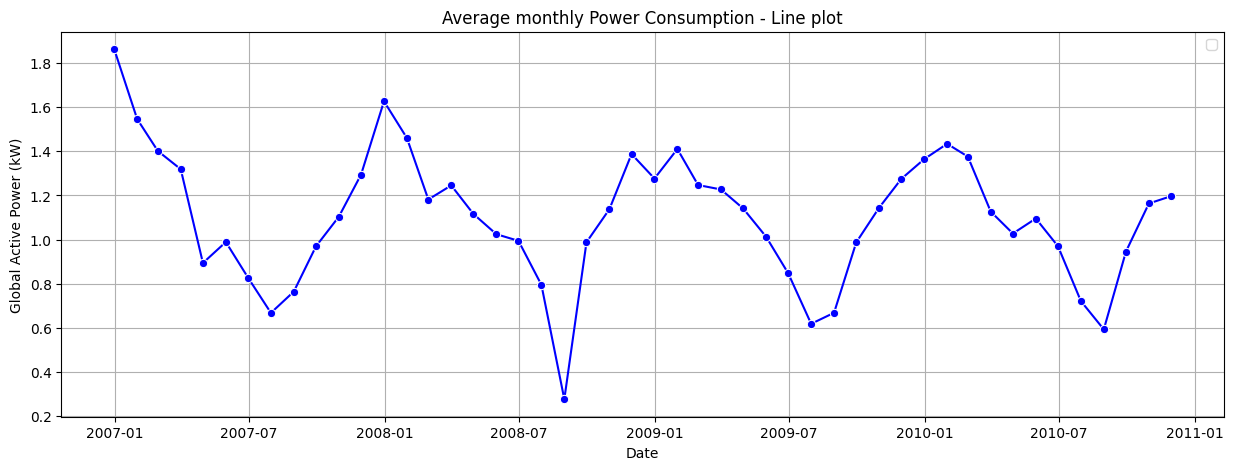

In [11]:
# Aggregate by month and calculate the average power consumption
monthly_avg = df_hourly.resample('M').mean()['Global_active_power']
# Plot monthly power consumption
plt.figure(figsize=(15, 5))
#plt.plot(monthly_avg.index, monthly_avg.values, label='Monthly Consumption', color='blue')
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker='o', color='blue')
plt.title('Average monthly Power Consumption - Line plot')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

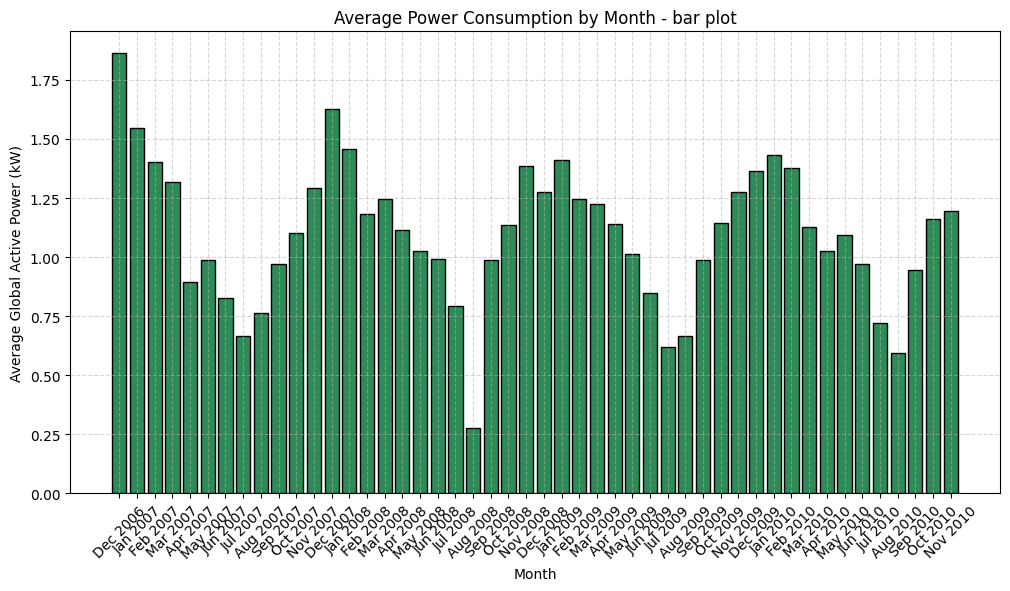

In [12]:
# Plot the histogram for monthly consumption
plt.figure(figsize=(12, 6))
plt.bar(monthly_avg.index.strftime('%b %Y'), monthly_avg.values, color='seagreen', edgecolor='black')
plt.title('Average Power Consumption by Month - bar plot')
plt.xlabel('Month')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<Axes: xlabel='hour', ylabel='Global_active_power'>

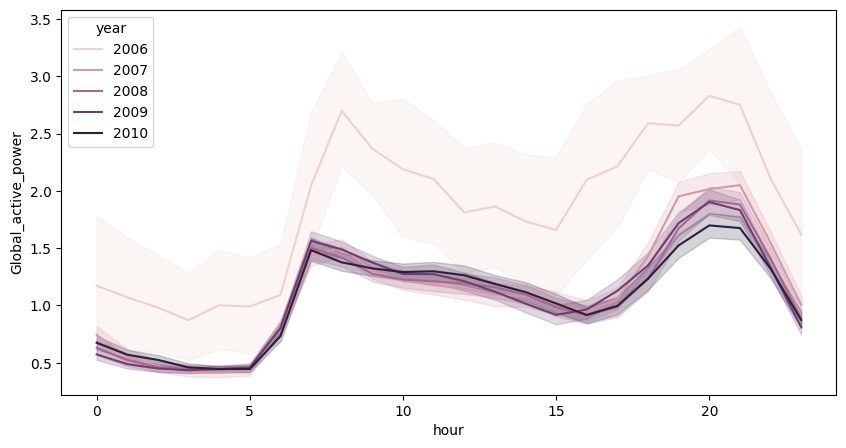

In [13]:
# Aggregate by month and calculate the average power consumption, years overlapped
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='Global_active_power', hue='year', data=df_hourly)

C:\Users\Teoman.Taskesen\AppData\Local\Temp\ipykernel_39128\1318486353.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg_each.index, y=monthly_avg_each.values, palette='Blues_d')


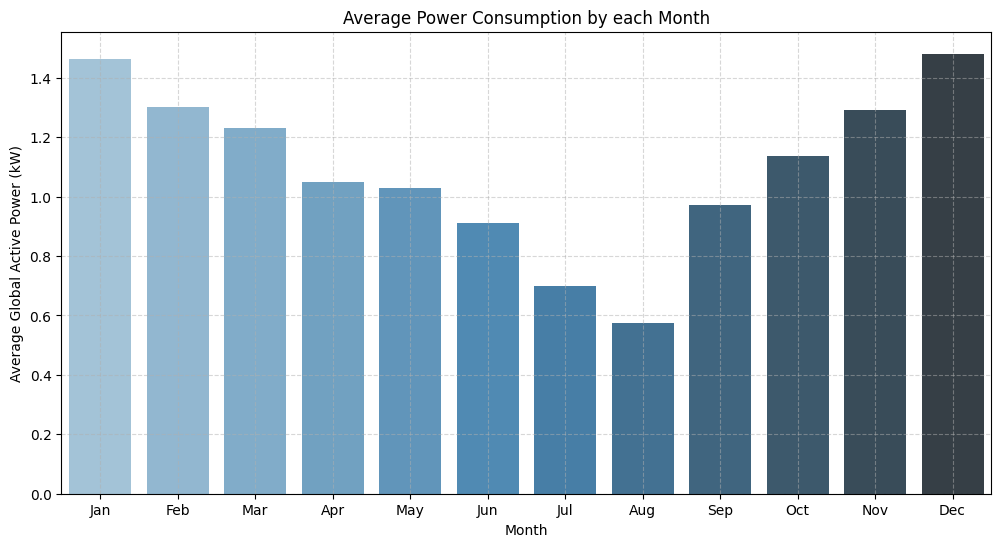

In [14]:
# Aggregate the data by each month and calculate the average power consumption
monthly_avg_each = df_hourly.groupby('month')['Global_active_power'].mean()

# Plotting the monthly power consumption using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_avg_each.index, y=monthly_avg_each.values, palette='Blues_d')

# Customize the plot
plt.title('Average Power Consumption by each Month')
plt.xlabel('Month')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

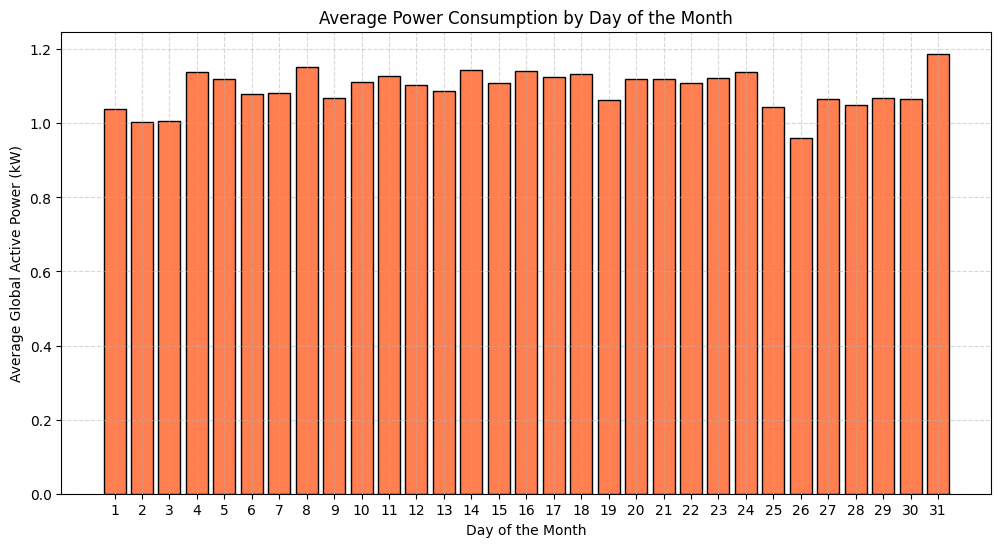

In [15]:
# Calculate average consumption by hour of the day
hourly_avg = df_hourly.groupby(df_hourly.index.hour)['Global_active_power'].mean()
# Resample to daily data
df_daily = df.resample('D', on='datetime').mean()
# Calculate average consumption by day of the month
daily_avg = df_daily.groupby(df_daily.index.day)['Global_active_power'].mean()
# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(daily_avg.index, daily_avg.values, color='coral', edgecolor='black')
plt.title('Average Power Consumption by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(range(1, 32))  # Show all days on the x-axis
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


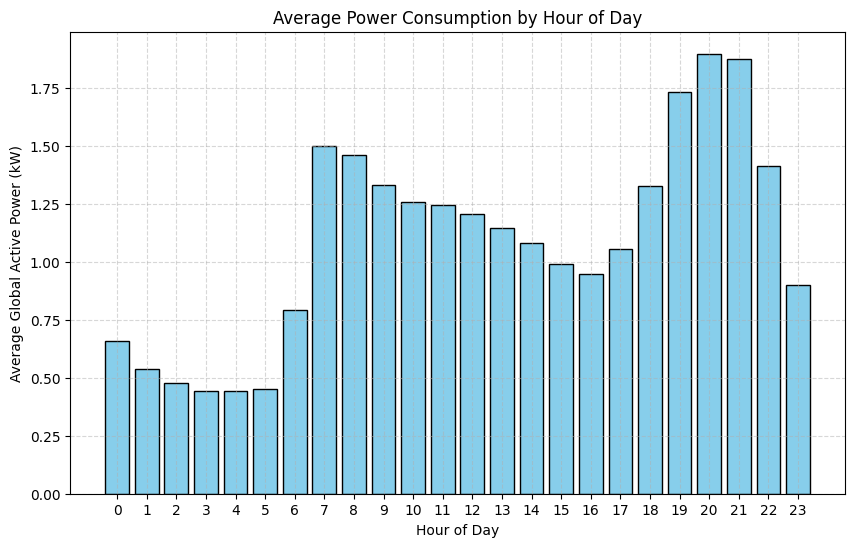

In [16]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(hourly_avg.index, hourly_avg.values, color='skyblue', edgecolor='black')
plt.title('Average Power Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(range(0, 24))  # Show all hours on the x-axis
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


C:\Users\Teoman.Taskesen\AppData\Local\Temp\ipykernel_39128\4054439149.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_of_week_avg.index, y=day_of_week_avg.values, palette='viridis')


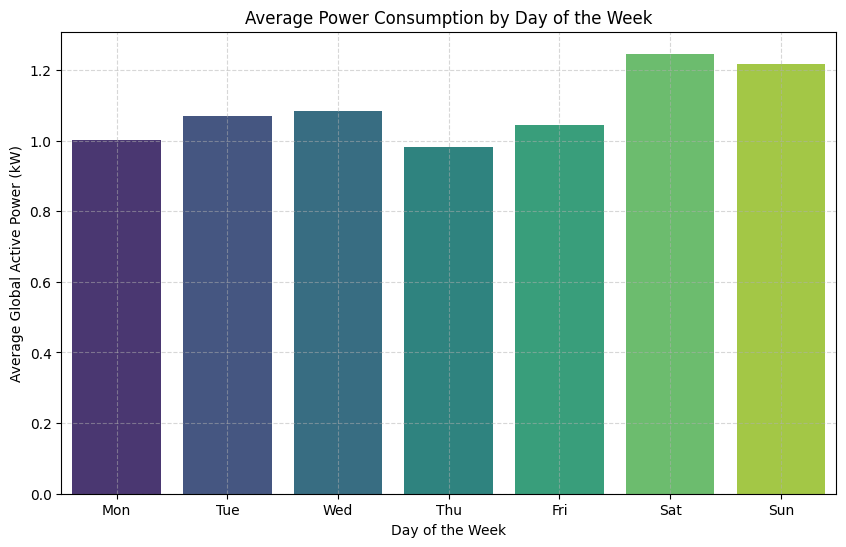

In [17]:

import matplotlib.pyplot as plt

# Aggregate the data by day of the week and calculate the average power consumption
day_of_week_avg = df_hourly.groupby('dayofweek')['Global_active_power'].mean()

# Plotting the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=day_of_week_avg.index, y=day_of_week_avg.values, palette='viridis')

# Customize the plot
plt.title('Average Power Consumption by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [18]:
df_hourly = df_hourly[['Global_active_power', 'hour', 'dayofweek', 'month', 'lag_1', 'lag_24']]

In [19]:
df_hourly.head()

,Global_active_power,hour,dayofweek,month,lag_1,lag_24
datetime,,,,,,
2006-12-17 17:00:00,3.406767,17,6,12,3.326033,4.222889
2006-12-17 18:00:00,3.697100,18,6,12,3.406767,3.632200
2006-12-17 19:00:00,2.908400,19,6,12,3.697100,3.400233
2006-12-17 20:00:00,3.361500,20,6,12,2.908400,3.268567
2006-12-17 21:00:00,3.040767,21,6,12,3.361500,3.056467


In [20]:
## Model power consumption only using the date information
# Define features and target
X = df_hourly.drop(columns='Global_active_power')
y = df_hourly['Global_active_power']

# Split data (using the last 20% as test data)
split_index = int(0.8 * len(df_hourly))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [21]:
# Initialize the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {round(mae,3)}')
print(f'Root Mean Squared Error (RMSE): {round(rmse,3)}')

Mean Absolute Error (MAE): 0.337
Root Mean Squared Error (RMSE): 0.483


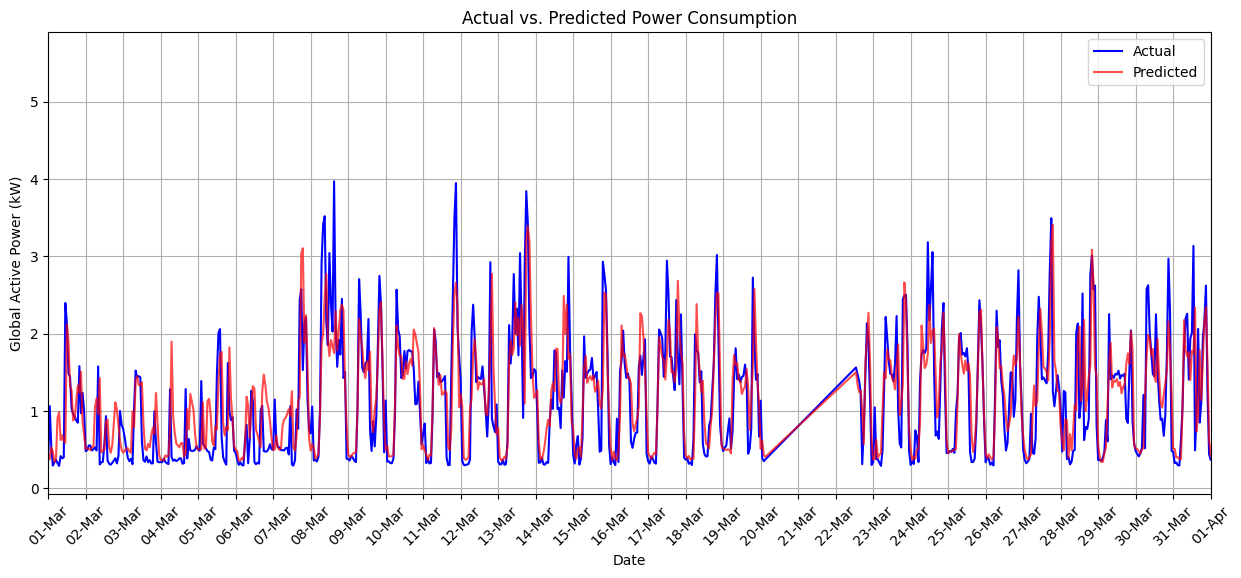

In [23]:
import matplotlib.dates as mdates

# Specify the start and finish dates for the plot
start_date = '2010-03-01'  # Modify this with the desired start date
end_date = '2010-04-01'    # Modify this with the desired end date

# Line Plot: Actual vs. Predicted with Modified X-Axis Scale
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Power Consumption')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)

# Set x-axis major ticks to daily intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Rotate and align x-ticks for better readability
plt.xticks(rotation=45)

# Set x-axis limits to specified start and end dates
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.show()




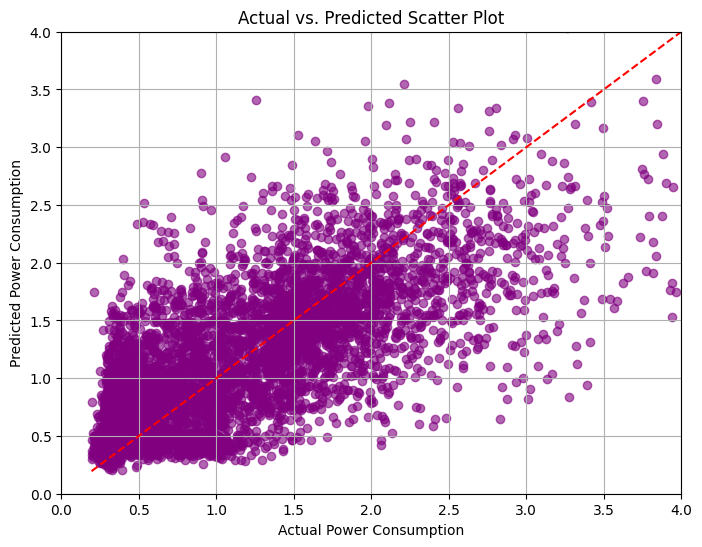

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs. Predicted Scatter Plot')
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption')
plt.grid(True)
plt.xlim(0,4)
plt.ylim(0,4)
plt.show()


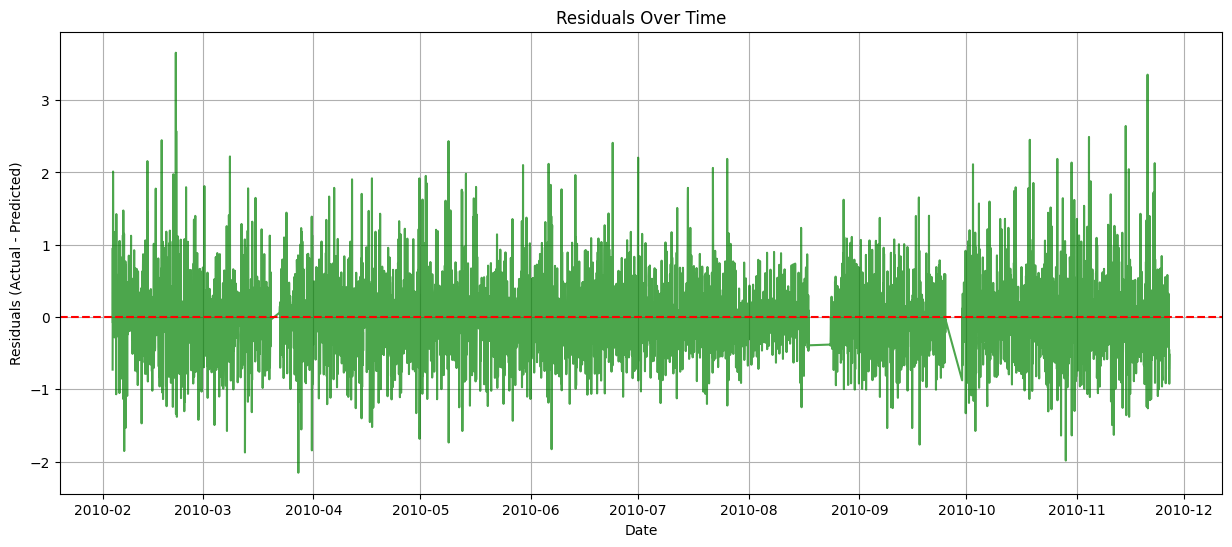

In [25]:
residuals = y_test - y_pred
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, residuals, color='green', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

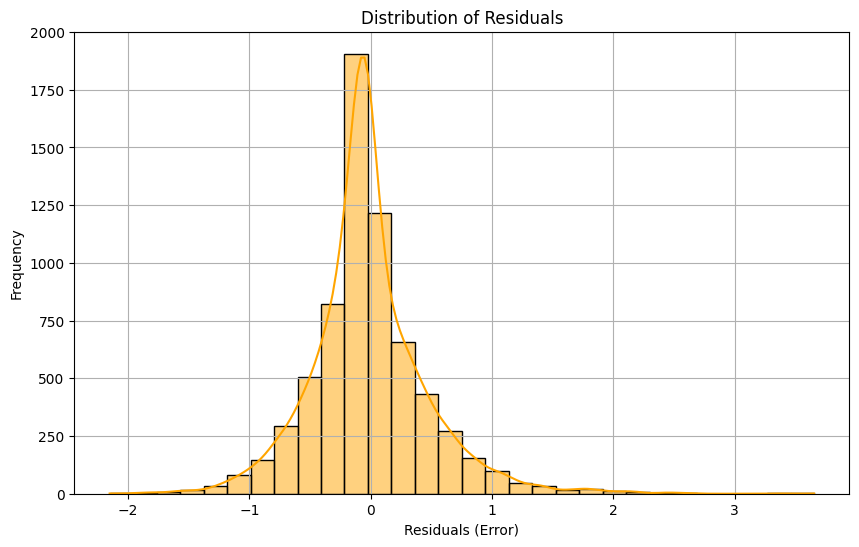

In [26]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Error)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [27]:
from datetime import datetime

# Specify the future date
future_date= '2023-03-10 14:00:00'

# Convert to datetime format
future_datetime = pd.to_datetime(future_date)

# Create the feature values (make sure they align with your model's features)
features = {
    'hour': future_datetime.hour,
    'dayofweek': future_datetime.dayofweek,  # 0=Monday, 6=Sunday
    'month': future_datetime.month,
    'lag_1': df_hourly['Global_active_power'].iloc[-1],  # Previous hour consumption (assumed)
    'lag_24': df_hourly['Global_active_power'].iloc[-24]  # Consumption from 24 hours ago
}

# Convert the features to a DataFrame
future_features = pd.DataFrame(features, index=[0])


In [28]:
future_features

,hour,dayofweek,month,lag_1,lag_24
0,14,4,3,0.934667,1.247567


In [29]:
# Use the trained model to make the prediction
future_prediction = model.predict(future_features)

# Display the predicted energy consumption for the future date
print(f"Predicted energy consumption for {future_date}: {future_prediction[0]:.3f} kW")

Predicted energy consumption for 2023-03-10 14:00:00: 0.883 kW
